## Read Data

In [478]:
import pandas as pd

there file was downloaded from https://www.kaggle.com/wendykan/lending-club-loan-data 

In [479]:
kaggle_data = pd.read_csv("C:/Users/jange/OneDrive/Dokumente/ML_Pipeline_Loan/loan.csv", low_memory = False)

## Preliminary Transformations (don't need to be run in prediction)

Filter Loans (don't use current loans)

In [480]:
kagge_data = kaggle_data[~kaggle_data.loan_status.isin(["Current", "Does not meet the credit policy. Status:Charged Off",
                                                       "Does not meet the credit policy. Status:Fully Paid", "Issued"])]

Create target variable

In [481]:
kaggle_data = kagge_data.assign(good_loan = pd.Series(kagge_data.loan_status == "Fully Paid"))

## Split Data into Training und Validation Set

In [482]:
from sklearn.model_selection import train_test_split

In [483]:
train_data, valid_data = train_test_split(kaggle_data,
                                           test_size = 0.25,
                                           random_state = 111)

## Define Target and Features 

In [484]:
target = "good_loan"
cat_features = ['home_ownership', 'purpose', 'addr_state']
num_features = ['loan_amnt', 'installment', 'annual_inc', 'int_rate', 'emp_length']
features = cat_features + num_features

In [485]:
positive_class = True

Data Types

In [524]:
kaggle_data[features].dtypes

home_ownership     object
purpose            object
addr_state         object
loan_amnt         float64
installment       float64
annual_inc        float64
int_rate          float64
emp_length         object
dtype: object

## Define Preprocessing

In [488]:
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

**Create Derived Features**

In [489]:
import re

In [529]:
class CreateDerivedFeatures(TransformerMixin, BaseEstimator):
    def __init__(self):
        self

    def fit(self, X, *_):
        return self
        
    def transform(self, X, *_):
        X_transformed = X.assign(loan_income_ratio = pd.Series(X.loan_amnt / X.annual_inc),
                                 interest_income_ratio = pd.Series((X.loan_amnt * 0.01 * X.int_rate)/ X.annual_inc),
                                 emp_length = pd.Series(X.emp_length.apply(emp_length_num)))
       
        return X_transformed
    
    def find_number(string):
        if (type(string) == float):
            first_number = float('NaN')
        else:
            first_number = int(re.findall(pattern = '(\d+)', string = string)[0])
        return first_number

    def emp_length_num(string):
        if (string == '< 1 year'):
        emp_length = 0
    else:
        emp_length = find_number(string)
    return emp_length


IndentationError: expected an indented block (<ipython-input-529-960d1dd9e87e>, line 16)

In [493]:
derive_step =('derive', CreateDerivedFeatures())
derive_features = Pipeline([derive_step])

**Categorical Features**

In [494]:
si_step_cat = ('si_cat', SimpleImputer(strategy = 'constant',
                                   fill_value= 'missing_value'))
ohe_step_cat = ('ohe_cat', OneHotEncoder(handle_unknown='ignore',
                                     sparse = False))

pipe_cat = Pipeline([si_step_cat, ohe_step_cat])

**Numerical Features**

In [495]:
si_step_num = ('si_num', SimpleImputer(strategy='constant',
                                       fill_value = -999))
pipe_num = Pipeline([si_step_num])

**Preprocessing**

In [496]:
from sklearn.compose import ColumnTransformer

In [497]:
preprocessor = ColumnTransformer(
    transformers = [
        ('cat', pipe_cat, cat_features),
        ('num', pipe_num, num_features)
    ])

## Define Classification Model

In [498]:
from sklearn.ensemble import RandomForestClassifier as rf

In [499]:
classifier = rf(n_estimators = 20, max_depth = 20)

## Combine Preprocessing and Classification into Pipeline

In [500]:
preprocessor_classifier = Pipeline([
    ('derive_features', derive_features),
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

## Training Modell

In [501]:
fitted_model = preprocessor_classifier.fit(X = train_data[features], y = train_data[target])

## Predictions Modell

In [502]:
train_scores = fitted_model.predict_proba(X = train_data)
train_predictions = fitted_model.predict(X = train_data)
valid_scores = fitted_model.predict_proba(X = valid_data)
valid_predictions = fitted_model.predict(X = valid_data)

## Evaluation Modell

**Classifier with Parameters**

In [503]:
classifier

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=20, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [504]:
index_positive = np.min(np.where(classifier.classes_ == positive_class))

**Feature Importance**

Here I would like to see the names of the features

In [387]:
top_n_features = 10

In [505]:
importances = fitted_model.named_steps['classifier'].feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(0,top_n_features):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

Feature ranking:
1. feature 74 (0.317701)
2. feature 73 (0.152397)
3. feature 72 (0.148530)
4. feature 71 (0.127778)
5. feature 75 (0.073850)
6. feature 1 (0.011436)
7. feature 5 (0.009585)
8. feature 8 (0.008469)
9. feature 7 (0.007044)
10. feature 4 (0.006292)


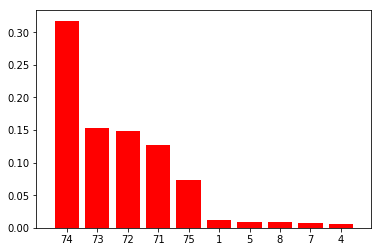

In [506]:
plt.figure()
plt.bar(range(0,top_n_features), importances[indices][0:top_n_features],
       color="r", align="center")
plt.xticks(range(0,top_n_features), indices)
plt.xlim([-1, top_n_features])
plt.show()

**Classification Report**

In [147]:
from sklearn.metrics import classification_report

Training Set

In [507]:
print(classification_report(y_true= train_data[target],
                      y_pred = train_predictions))

              precision    recall  f1-score   support

       False       0.95      0.17      0.28     50071
        True       0.79      1.00      0.88    155722

   micro avg       0.80      0.80      0.80    205793
   macro avg       0.87      0.58      0.58    205793
weighted avg       0.83      0.80      0.74    205793



Validation Set

In [508]:
print(classification_report(y_true= valid_data[target],
                      y_pred = valid_predictions))

              precision    recall  f1-score   support

       False       0.55      0.06      0.11     16597
        True       0.77      0.98      0.86     52001

   micro avg       0.76      0.76      0.76     68598
   macro avg       0.66      0.52      0.48     68598
weighted avg       0.71      0.76      0.68     68598



**Confusion Matrix**

In [78]:
from sklearn.metrics import confusion_matrix

In [509]:
confusion_matrix(y_true = valid_data[target],
                 y_pred = valid_predictions)

array([[  992, 15605],
       [  822, 51179]], dtype=int64)

**ROC**

In [80]:
from sklearn.metrics import roc_auc_score, roc_curve

In [513]:
roc_auc_score(y_true= valid_data[target],
              y_score = valid_scores[:,index_positive])

0.6798667828650737

In [82]:
import matplotlib.pyplot as plt

In [511]:
fpr, tpr, thresholds = roc_curve(y_true= valid_data[target], y_score=valid_scores[:,index_positive])

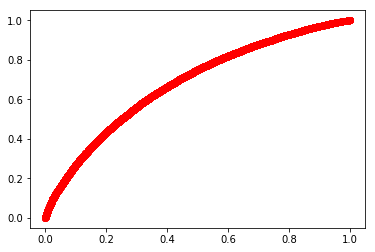

In [512]:
plt.plot(fpr, tpr, 'ro')

**Example Predictions**

In [329]:
valid_data_predictions = valid_data.assign(scores = pd.Series(valid_scores[:,index_positive]).values)

In [330]:
high_predictions = valid_data_predictions[valid_data_predictions.scores > 0.98]

In [331]:
high_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
200681,1476597,1734402,4000.0,4000.0,3950.0,36 months,6.62,122.82,A,A2,...,NaN,NaN,NaN,NaN,12200.0,NaN,NaN,NaN,True,0.980704
159154,3628427,4580852,2300.0,2300.0,2300.0,36 months,6.62,70.62,A,A2,...,NaN,NaN,NaN,NaN,16500.0,NaN,NaN,NaN,True,0.980987
27639,551197,710362,6000.0,6000.0,6000.0,36 months,6.76,184.61,A,A2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.983132
187116,1814879,2117064,2800.0,2800.0,2800.0,36 months,6.03,85.22,A,A1,...,NaN,NaN,NaN,NaN,70000.0,NaN,NaN,NaN,True,0.980058
189915,1637526,1909853,3000.0,3000.0,3000.0,36 months,6.62,92.12,A,A2,...,NaN,NaN,NaN,NaN,65000.0,NaN,NaN,NaN,True,0.982360
141941,4805994,6068217,28000.0,28000.0,28000.0,36 months,7.62,872.52,A,A3,...,NaN,NaN,NaN,NaN,213700.0,NaN,NaN,NaN,True,0.981379
218314,1268334,1512171,23000.0,23000.0,23000.0,36 months,7.62,716.72,A,A3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,0.985672


In [334]:
low_predictions = valid_data_predictions[valid_data_predictions.scores < 0.3]

In [335]:
low_predictions.head(20)

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,good_loan,scores
607418,59139505,63027235,25000.0,25000.0,25000.0,60 months,20.99,676.20,E,E5,...,NaN,NaN,NaN,NaN,42200.0,NaN,NaN,NaN,True,0.295338
93836,7048231,8710292,11100.0,11100.0,11100.0,60 months,21.60,304.06,E,E3,...,NaN,NaN,NaN,NaN,33500.0,NaN,NaN,NaN,False,0.269439
441363,11445019,13377179,15325.0,15325.0,15325.0,60 months,25.80,457.03,G,G1,...,NaN,NaN,NaN,NaN,6800.0,NaN,NaN,NaN,False,0.265956
287313,30264912,32808074,30625.0,30625.0,30600.0,60 months,26.06,918.02,G,G5,...,NaN,NaN,NaN,NaN,5500.0,NaN,NaN,NaN,False,0.296318
319268,25366753,27809584,10800.0,10800.0,10800.0,60 months,24.50,313.84,F,F3,...,NaN,NaN,NaN,NaN,22100.0,NaN,NaN,NaN,True,0.268847
390260,16052016,18154447,17075.0,17075.0,17075.0,60 months,25.80,509.22,G,G1,...,NaN,NaN,NaN,NaN,17300.0,NaN,NaN,NaN,True,0.278243
125921,5789590,7221655,12175.0,12175.0,12175.0,60 months,23.76,348.56,F,F4,...,NaN,NaN,NaN,NaN,24900.0,NaN,NaN,NaN,False,0.208166
384137,16342957,18445374,15925.0,15925.0,15875.0,60 months,20.99,430.74,E,E4,...,NaN,NaN,NaN,NaN,24400.0,NaN,NaN,NaN,True,0.291760


# Experimental Area